# Andrew's model work for Milestone 4, based on David's

In [1]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

In [2]:
### specify processed data files to generate - full/partial, partial %, and train/test
### Note: this cell is the same in both notebooks

# load and clean full dataset?
load_full = False

# if not loading and cleaning full dataset, what sample percentage?
sample_percent = 10

if load_full:
    pct_str = ""
else: # not load_full
    pct_str = str(sample_percent) + "_pct"
    
# use training or testing data to generate minor files?
minor_use_train = True
if minor_use_train:
    mode_str = "train"
else: # not minor_use_train
    mode_str = "test"
    
### set intermediate file names
dir_str = "./intermediate_files/"

processed_data_train_file = dir_str + "processed_data_" + "train" + pct_str + ".json"
processed_data_test_file = dir_str + "processed_data_" + "test" + pct_str + ".json"

nlp_data_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
nlp_data_train_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
term_freqs_file = dir_str + "term_freqs_" + mode_str + pct_str + ".mtx"
diff_terms_file = dir_str + "diff_terms_" + mode_str + pct_str + ".json"

In [3]:
### load processed data
data = pd.read_json(processed_data_train_file)
data_nlp = pd.read_json(nlp_data_file)
desc_matrix_coo = mmread(term_freqs_file)
desc_matrix = sp.sparse.csr_matrix(desc_matrix_coo)
count_cols_df = pd.read_json(diff_terms_file)

count_cols_bool = count_cols_df.values > 0.0

In [36]:
x = data.drop('loan_status', 1)
y = data['loan_status']

x_nlp = data_nlp.drop('loan_status', 1)
y_nlp = data_nlp['loan_status']

# Explore and clean up and standardize data

In [5]:
pd.to_datetime(x.issue_date).dt.year.value_counts()

2013    4975
2014    4899
2012    3424
2015    1842
2011    1400
2010     809
2009     314
2008      98
Name: issue_date, dtype: int64

In [6]:
# del x['verif_status']
x.describe().T

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,count,mean,std,min,25%,50%,75%,max
annual_income,17761.0,72333.158049,59471.311101,4.800000e+03,45000.000000,62000.000000,86547.000000,5.000000e+06
cpi,17761.0,0.020896,0.000708,1.959402e-02,0.020243,0.020924,0.021465,2.321584e-02
delinq_2_yrs,17761.0,0.209166,0.511465,0.000000e+00,0.000000,0.000000,0.000000,2.000000e+00
desc_len,6178.0,290.221916,312.163505,1.000000e+00,NaN,NaN,NaN,4.459000e+03
dti,17761.0,0.002416,0.001123,0.000000e+00,0.001581,0.002373,0.003228,5.458308e-03
gdp,17761.0,0.999739,0.000037,9.995188e-01,0.999716,0.999745,0.999766,9.998077e-01
index,17761.0,255087.730702,217690.844714,0.000000e+00,100498.000000,197176.000000,363917.000000,8.873710e+05
inquiry_6_mos,17761.0,0.809245,0.965676,0.000000e+00,0.000000,1.000000,1.000000,3.000000e+00
installment,17761.0,418.074954,245.415704,2.181000e+01,239.550000,365.810000,547.460000,1.408130e+03
interest_rate,17761.0,13.727266,4.355741,5.320000e+00,10.740000,13.530000,16.320000,2.849000e+01


In [7]:
x.columns

Index([u'address_state', u'annual_income', u'cpi', u'delinq_2_yrs',
       u'desc_len', u'description', u'dti', u'earliest_credit',
       u'employ_length', u'employ_title', u'gdp', u'home_owner', u'index',
       u'initial_list_status', u'inquiry_6_mos', u'installment',
       u'interest_rate', u'ipr', u'issue_date', u'loan_amount',
       u'loan_purpose', u'loan_subgrade', u'loan_term',
       u'months_since_last_record', u'open_accounts', u'revol_util', u'rir',
       u'total_accounts', u'unemploy', u'verif_status'],
      dtype='object')

In [19]:
def expand_x(x, x_orig):
    x_expanded = pd.DataFrame()
    for colname in x.columns:
        print colname, x[colname].dtype
        if colname in ('description', 'verif_status'):
            continue
        if x[colname].dtype == 'object':
            values = x[colname].fillna('MISSING')
            value_columns = values.value_counts().index
            if len(value_columns) > 50:
                value_columns = value_columns[:50]
            for val in value_columns:
                x_expanded[colname + '__' + val.replace(' ', '_')] = (values == val).astype(int)
        else:
            values = x[colname].fillna(x[colname].median())
            sd = np.nanstd(x_orig[colname])
            if sd < 1e-10:
                sd = 1
            x_expanded[colname] = (values - np.nanmean(x_orig[colname]))/sd
    return x_expanded

In [20]:
x_expanded = expand_x(x, x)

address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
description object
dti float64
earliest_credit object
employ_length object
employ_title object
gdp float64
home_owner object
index int64
initial_list_status object
inquiry_6_mos int64
installment float64
interest_rate float64
ipr float64
issue_date object
loan_amount int64
loan_purpose object
loan_subgrade int64
loan_term int64
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
verif_status float64


In [21]:
x_expanded.describe().T

,count,mean,std,min,25%,50%,75%,max
address_state__CA,17761.0,1.721187e-01,0.377494,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__NY,17761.0,8.394798e-02,0.277318,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__TX,17761.0,7.904960e-02,0.269824,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__FL,17761.0,6.739485e-02,0.250712,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__NJ,17761.0,3.969371e-02,0.195244,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__IL,17761.0,3.614661e-02,0.186660,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__PA,17761.0,3.417600e-02,0.181686,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__GA,17761.0,3.237430e-02,0.176997,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__OH,17761.0,3.124824e-02,0.173993,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__VA,17761.0,3.102303e-02,0.173385,0.000000,0.000000,0.000000,0.000000,1.000000


In [22]:
x_expanded.columns

Index([u'address_state__CA', u'address_state__NY', u'address_state__TX',
       u'address_state__FL', u'address_state__NJ', u'address_state__IL',
       u'address_state__PA', u'address_state__GA', u'address_state__OH',
       u'address_state__VA',
       ...
       u'loan_purpose__renewable_energy', u'loan_purpose__educational',
       u'loan_subgrade', u'loan_term', u'months_since_last_record',
       u'open_accounts', u'revol_util', u'rir', u'total_accounts',
       u'unemploy'],
      dtype='object', length=251)

In [48]:
# be prepared to split stuff up by year of issue
years = pd.to_datetime(x.issue_date).dt.year

# Start evaluating models

In [47]:
for yr in set(years.values):
    rf = RFC(random_state=1729,
             max_depth=5,
             n_estimators=100,
             oob_score=True
            ).fit(x_expanded[years==yr], y[years==yr])
    print yr, rf.oob_score_, 1-y[years==yr].mean()

2008 0.785714285714 0.785714285714
2009 0.853503184713 0.853503184713
2010 0.864029666255 0.864029666255
2011 0.839285714286 0.839285714286
2012 0.832651869159 0.832651869159
2013 0.797989949749 0.797989949749
2014 0.803225147989 0.803225147989
2015 0.899022801303 0.899022801303


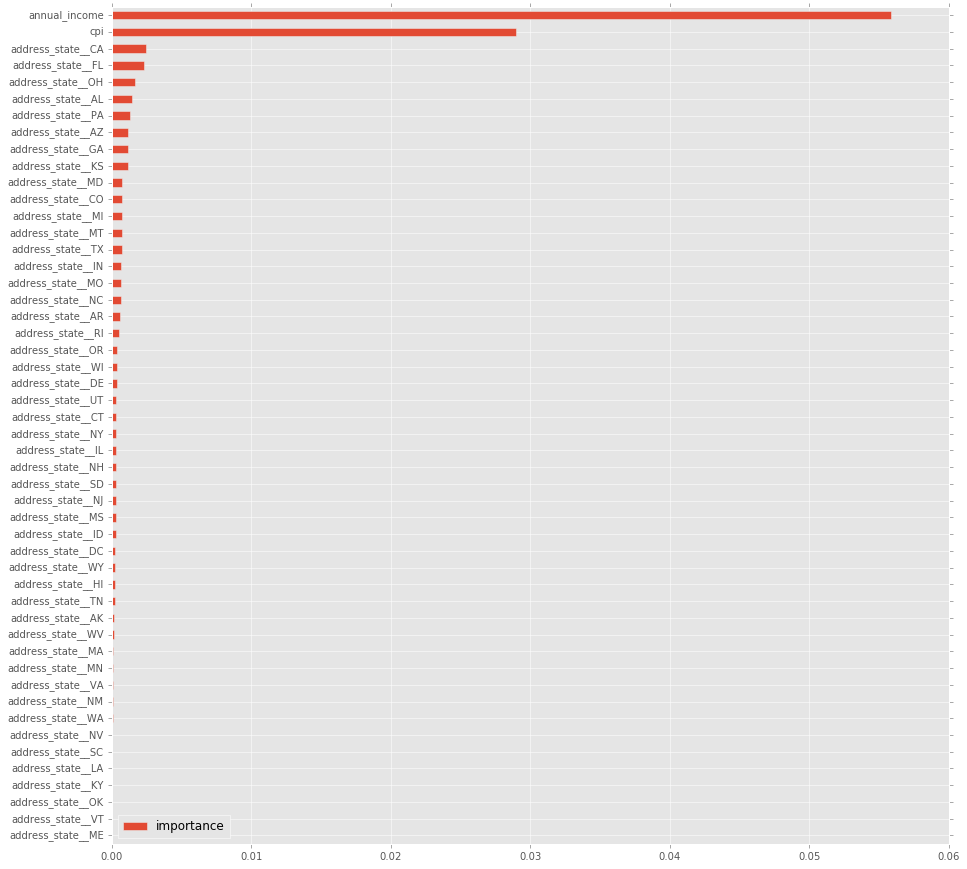

In [53]:
# One RF with all years combined; what predictors matter?
rf = RFC(random_state=1729,
         max_depth=5,
         n_estimators=100,
         oob_score=True
        ).fit(x_expanded, y)
plt.figure(figsize=(15,15))
pd.DataFrame(rf.feature_importances_, 
             index=x_expanded.columns,
             columns=['importance'],
             ).iloc[0:50,:].sort_values(by='importance',
                           ascending=True,
             ).plot(kind='barh', ax=plt.gca())
plt.show()

In [61]:
def eval_model_by_year(model_factory):
    for yr in set(years.values):
        model = model_factory().fit(x_expanded[years==yr], y[years==yr])
        score = model.score(x_expanded[years==yr], y[years==yr])
        print yr, "  score:", score, " baseline:", 1-y[years==yr].mean()  
# TODO: k-fold cross-validation
# TODO: Confusion matrix (right now, we're not doing well enough to worry about that)
# TODO: Pretty-print
# TODO: Store results to allow side-by-side

In [62]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'))

2008   score: 0.918367346939  baseline: 0.785714285714
2009   score: 0.863057324841  baseline: 0.853503184713
2010   score: 0.734239802225  baseline: 0.864029666255
2011   score: 0.732857142857  baseline: 0.839285714286
2012   score: 0.696845794393  baseline: 0.832651869159
2013   score: 0.677788944724  baseline: 0.797989949749
2014   score: 0.693406817718  baseline: 0.803225147989
2015   score: 0.758414766558  baseline: 0.899022801303


In [63]:
eval_model_by_year(lambda: QDA())

2008   score: 1.0  baseline: 0.785714285714
2009   score: 0.87898089172  baseline: 0.853503184713
2010   score: 0.865265760198  baseline: 0.864029666255
2011   score: 0.891428571429  baseline: 0.839285714286
2012   score: 0.199474299065  baseline: 0.832651869159
2013   score: 0.223115577889  baseline: 0.797989949749
2014   score: 0.287405592978  baseline: 0.803225147989
2015   score: 0.900108577633  baseline: 0.899022801303


In [64]:
eval_model_by_year(lambda: SVC(class_weight='balanced'))

2008   score: 0.714285714286  baseline: 0.785714285714
2009   score: 0.691082802548  baseline: 0.853503184713
2010   score: 0.658838071693  baseline: 0.864029666255
2011   score: 0.717142857143  baseline: 0.839285714286
2012   score: 0.702686915888  baseline: 0.832651869159
2013   score: 0.648040201005  baseline: 0.797989949749
2014   score: 0.689324351909  baseline: 0.803225147989
2015   score: 0.676438653637  baseline: 0.899022801303


In [65]:
# TODO: Try again, this time fitting a regression against the payments received